In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


from typing import List
import json
from statistics import mean
import random
random.seed(42)

rootpath = ".."

degree_sign = u'\N{DEGREE SIGN}'

In [16]:
result_filename = f"{rootpath}/results/result_data/transfer_results.json"

with open(result_filename, "r") as f:
    results_data = json.load(f)

ft_percents = results_data["options"]["ft_percents"]
shuffle_seeds = results_data["options"]["seeds"]
transfer_methods = ["weight_initialization_LSTMDense", "weight_initialization_AutoLSTM","weight_initialization_AdjMLP"]
tm = transfer_methods[2]

In [17]:
# Create a subplots figure with two subplots and set title
x = [fp * 100 for fp in ft_percents]

# initialize the dataframe for pir values
keys = [building+tower+"_"+season for building in ["ESB", "Kissam"] for tower in ["1","2"] for season in ["summer", "fall"]]
pir_df = pd.DataFrame([[None] * len(keys)] * len(keys), columns=keys)
pir_df['index'] = keys
pir_df.set_index("index", inplace=True)

mae_df = pd.DataFrame([[None] * len(keys)] * len(keys), columns=keys)
mae_df['index'] = keys
mae_df.set_index("index", inplace=True)

def calcPir(base_error, transfer_error):
    if base_error == 0: raise ValueError("Base error is 0")
    return (base_error - transfer_error) / base_error

for from_key in keys:
    for to_key in keys:

        if to_key == from_key: 
            pir_df.loc[to_key, from_key] = 0
            continue
        try:
            base_mae = results_data[tm][to_key]["base"]["mae"]

            # # AVERAGE MAE METHOD
            avgm = [0.0] * len(ft_percents)
            
            for i, ft in enumerate([f"ft{int(fp * 100)}" for fp in ft_percents]):
                # print(tm, from_key, to_key, ft, base_mae)
                # print(results_data[tm][from_key][to_key][ft]["mae"])
                if None in results_data[tm][from_key][to_key][ft]["mae"]: raise ValueError("Skip this graph")
                avgm[i] = mean(results_data[tm][from_key][to_key][ft]["mae"])
            
            pir_list = [calcPir(base_mae, x) for x in avgm]
            pir_df.loc[to_key, from_key] = max(pir_list)
            mae_df.loc[to_key, from_key] = min(avgm)
            

            # # LOWEST MAE METHOD
            # min_mae_list = [0.0] * len(ft_percents)
            # for i, ft in enumerate([f"ft{int(fp * 100)}" for fp in ft_percents]):
            #     if None in results_data[tm][from_key][to_key][ft]["mae"]: raise ValueError("Skip this graph")
            #     min_mae_list[i] = min(results_data[tm][from_key][to_key][ft]["mae"])
            # pir_list = [calcPir(base_mae, x) for x in min_mae_list]
            # pir_df.loc[to_key, from_key] = max(pir_list)
            
        except: continue # in case of null values (transfers that have not been run yet)

In [18]:
pd.set_option("display.precision", 2)
print(mae_df)

               ESB1_summer ESB1_fall ESB2_summer ESB2_fall Kissam1_summer  \
index                                                                       
ESB1_summer           None      19.4       12.17      15.8          28.64   
ESB1_fall            11.79      None       11.74     14.86           24.8   
ESB2_summer           9.41     16.75        None     13.34          21.66   
ESB2_fall            14.02     17.72       16.49      None          33.75   
Kissam1_summer       16.31     22.43       17.99     18.79           None   
Kissam1_fall         20.59     21.83       28.24     33.26          16.23   
Kissam2_summer       15.46     23.57       18.36     18.19          19.63   
Kissam2_fall         23.15     30.92       30.17     34.57          23.36   

               Kissam1_fall Kissam2_summer Kissam2_fall  
index                                                    
ESB1_summer           11.18          30.67        10.35  
ESB1_fall              11.9          78.37        11.51

## Heatmap

<Axes: ylabel='index'>

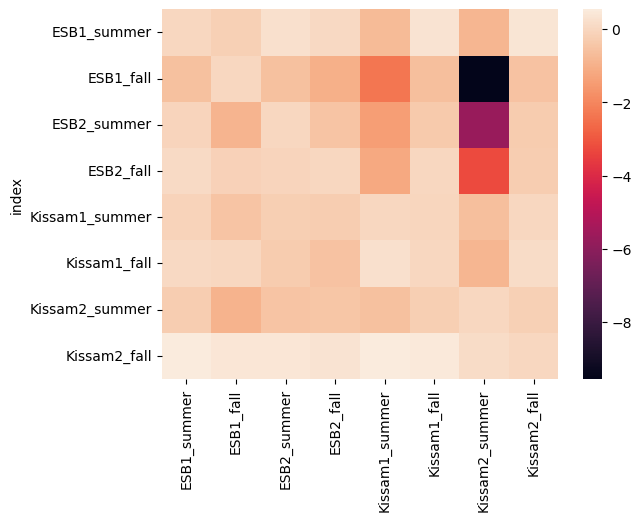

In [19]:
pir_df = pir_df.astype(float)
sns.heatmap(pir_df)

In [20]:
## 3D Bad chart

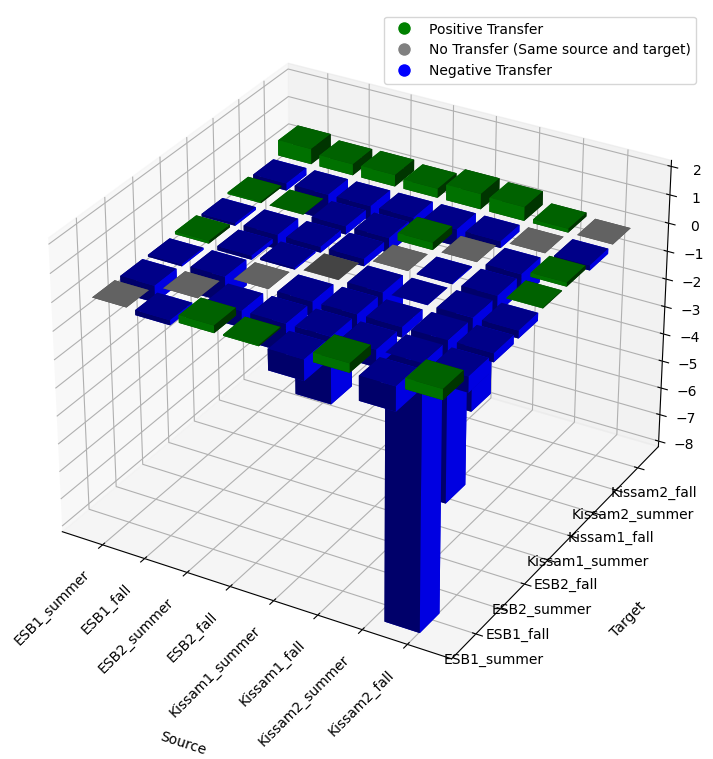

In [24]:
df = pir_df
index_labels = keys

# Create a 3D figure
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

# Create numeric indices for x and y axes
x_indices = np.arange(len(keys))
y_indices = np.arange(len(df.columns))

# Create 2D meshgrid
x, y = np.meshgrid(x_indices, y_indices)

# Flatten indices and values
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = df.values.flatten()

# Color all bars with positive z values in green
colors = ['green' if val > 0 else 'grey' if val == 0 else 'blue' for val in z_flat]

# Create 3D bar plot with adjusted alpha 
bars = ax.bar3d(x_flat, y_flat, np.zeros_like(z_flat), 0.8, 0.8, z_flat, shade=True, color=colors)

# Set axis labels
ax.set_xlabel('Source', labelpad=55)
ax.set_ylabel('Target', labelpad=25)
ax.set_zlabel('Values', labelpad=10)

# Set tick labels
ax.set_xticks(x_indices + 0.4)
ax.set_xticklabels(keys)
ax.set_yticks(y_indices + 0.4)
ax.set_yticklabels(df.columns)
ax.set_zticks(np.arange(-8, 3, 1))

# Rotate the x-axis labels for better visibility
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Create legend
legend_labels = ['Positive Transfer', 'No Transfer (Same source and target)', 'Negative Transfer']
legend_colors = ['green', 'grey', 'blue']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors]
ax.legend(legend_handles, legend_labels, loc='upper right')

# Display the plot
plt.show()


In [11]:
# Create 3D bar plot using Plotly
fig = go.Figure()

# Add surface plot
fig.add_trace(go.Surface(
    z=df.values,
    x=df.columns,
    y=index_labels,
    colorscale='Viridis',  # choose a colorscale
    colorbar=dict(title='Values'),
))

# Update layout
fig.update_layout(
    scene=dict(
        xaxis=dict(title='Source'),
        yaxis=dict(title='Target'),
        zaxis=dict(title='PIR'),
    ),
    margin=dict(l=0, r=0, b=0, t=40),
)

# Show the plot
fig.show()

## Add PIR results to the results dict

In [12]:
# Create a subplots figure with two subplots and set title
x = [fp * 100 for fp in ft_percents]

# initialize the dataframe for pir values
keys = [building+tower+"_"+season for building in ["ESB", "Kissam"] for tower in ["1","2"] for season in ["summer", "fall"]]
pir_df = pd.DataFrame([[None] * len(keys)] * len(keys), columns=keys)
pir_df['index'] = keys
pir_df.set_index("index", inplace=True)

mae_df = pd.DataFrame([[None] * len(keys)] * len(keys), columns=keys)
mae_df['index'] = keys
mae_df.set_index("index", inplace=True)

def calcPir(base_error, transfer_error):
    if base_error == 0: raise ValueError("Base error is 0")
    return (base_error - transfer_error) / base_error

whoops = 0
for from_key in keys:
    for to_key in keys:

        if to_key == from_key: 
            pir_df.loc[to_key, from_key] = 0
            continue
        try:
            base_mae = results_data[tm][to_key]["base"]["mae"]

            # # AVERAGE MAE METHOD
            avgm = [0.0] * len(ft_percents)
            
            for i, ft in enumerate([f"ft{int(fp * 100)}" for fp in ft_percents]):
                # print(tm, from_key, to_key, ft, base_mae)
                # print(results_data[tm][from_key][to_key][ft]["mae"])
                if None in results_data[tm][from_key][to_key][ft]["mae"]: raise ValueError("Skip this graph")
                avgm[i] = mean(results_data[tm][from_key][to_key][ft]["mae"])
                results_data[tm][from_key][to_key][ft]["pir"] = calcPir(base_mae, avgm[i])
            
            pir_list = [calcPir(base_mae, x) for x in avgm]
            pir_df.loc[to_key, from_key] = pir_list
            
        except: 
            print(from_key, to_key)
            whoops+=1 # in case of null values (transfers that have not been run yet)
print(whoops)

0


In [13]:
def get_building(input_string):
    # Find the index of the first digit in the string
    digit_index = next(i for i, char in enumerate(input_string) if char.isdigit())
    
    # Extract the building substring
    building = input_string[:digit_index]
    
    return building

def get_building_number(input_string):
    # Find the index of the first digit in the string
    digit_index = next(i for i, char in enumerate(input_string) if char.isdigit())
    
    # Extract the building number substring
    building_number = input_string[digit_index:]
    
    return building_number

def get_season(input_string):
    # Find the index of the underscore character
    underscore_index = input_string.index('_')
    
    # Extract the season substring
    season = input_string[underscore_index + 1:]
    
    return season

In [ ]:
# Create a subplots figure with two subplots and set title
x = [fp * 100 for fp in ft_percents]

# initialize the dataframe for pir values
keys = [b1+t1+"_"+s1 for b1 in ["ESB", "Kissam"] for t1 in ["1","2"] for s1 in ["summer", "fall"]]
pir_df = pd.DataFrame([[None] * len(keys)] * len(keys), columns=keys)
pir_df['index'] = keys
pir_df.set_index("index", inplace=True)

mae_df = pd.DataFrame([[None] * len(keys)] * len(keys), columns=keys)
mae_df['index'] = keys
mae_df.set_index("index", inplace=True)

def calcPir(base_error, transfer_error):
    if base_error == 0: raise ValueError("Base error is 0")
    return (base_error - transfer_error) / base_error

whoops = 0
pir_list = []
for f_i, fp in enumerate(ft_percents):
    pir_list.append([])
    for from_key in keys:
        for to_key in keys:
            if to_key == from_key:
                continue
            # intrabuilding, interseason only
            # if get_building(to_key) != get_building(from_key) or get_season(from_key) == get_season(to_key): continue
            # interbuilding, intraseason only
            # if get_building(to_key) == get_building(from_key) or get_season(from_key) != get_season(to_key): continue
            try:
                base_mae = results_data[tm][to_key]["base"]["mae"]
                pir_list[f_i].append(results_data[tm][from_key][to_key][f"ft{int(fp * 100)}"]["pir"])

                
            except: whoops+=1 # in case of null values (transfers that have not been run yet)
print(whoops)

In [ ]:
mean(pir_list[4])